In [1]:
!pip install rioxarray==0.15.0
!pip install stackstac==0.5.1
!pip install planetary-computer==1.0.0
!pip install odc-stac==0.3.11
!pip install rasterio==1.3.6
!pip install pystac==1.11.0
!pip install geopandas
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 83.8 MB/s eta 0:00:00
  Attempting uninstall: rasterio
    Found existing installation: rasterio 1.4.3
    Uninstalling rasterio-1.4.3:
      Successfully uninstalled rasterio-1.4.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: pystac
    Found existing installation: pystac 1.12.2
    Uninstalling pystac-1.12.2:
      Successfully u

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import stackstac
from odc.stac import stac_load
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm
from datetime import datetime as dt

In [4]:
CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/Training_data_uhi_index_2025-02-18.csv'

df = pd.read_csv(CSV_PATH)
df.head(100)

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634
...,...,...,...,...
95,-73.908298,40.807238,24-07-2021 15:55,1.000237
96,-73.908363,40.807048,24-07-2021 15:56,1.000237
97,-73.908397,40.806955,24-07-2021 15:56,1.000358
98,-73.908428,40.806872,24-07-2021 15:56,1.000358


Shared variables

In [5]:
#define boundary and date to fetch from
lower_left = tuple(round(num, 2) for num in (df['Latitude'].min()-0.01, df['Longitude'].min()-0.01))
upper_right = tuple(round(num, 2) for num in (df['Latitude'].max()+0.01, df['Longitude'].max()+0.01))
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

#year-month-day

try:
  df['datetime'] = pd.to_datetime(df['datetime'].str[0:10], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
  datetime = dt.strptime(df['datetime'][0], '%Y-%m-%d')
except:
  print(None)

min_time = str(datetime.year) + '-' + str(datetime.month - 1).zfill(2) + '-' + '01'
max_time = str(datetime.year) + '-' + str(datetime.month + 2).zfill(2) + '-' + '01'
time_window = min_time + '/' + max_time
#scale and resolution

resolution = 30  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326
df['datetime']

,datetime
0,2021-07-24
1,2021-07-24
2,2021-07-24
3,2021-07-24
4,2021-07-24
...,...
11224,2021-07-24
11225,2021-07-24
11226,2021-07-24
11227,2021-07-24


Fetching satellite data (LandSat + Sentinel_2)

In [6]:
#extract data (landsat)
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search_landsat = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 10},"platform": {"in": ["landsat-8"]}},
)


search_sentinel = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 10}},
)


In [7]:
def get_item(search):
  items = list(search.get_items())
  signed_items = [pc.sign(item).to_dict() for item in items]
  return items

items_landsat = get_item(search_landsat)
items_sentinel = get_item(search_sentinel)


In [8]:
"""
B02 = Blue = 10m
B03 = Green = 10m
B04 = Red = 10m

B8A = NIR (narrow 864 nm) = 20m

"""

data_landsat = stac_load(
    items_landsat,
    bands=["lwir11"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url= pc.sign,
    bbox=bounds
)

#For illustration (separate)
scene_data_landsat = stac_load(
    items_landsat,
    bands=["red", "green", "blue", "nir08"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url= pc.sign,
    bbox=bounds
)

data_sentinel = stac_load(
    items_sentinel,
    bands=['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12'],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bounds
)


In [9]:
#cache the data
data_landsat = data_landsat.persist()
scene_data_landsat = scene_data_landsat.persist()
data_sentinel = data_sentinel.persist()


In [10]:
# Scale Factors for the RGB bands
scale1 = 0.0000275
offset1 = -0.2
scene_data_landsat = scene_data_landsat.astype(float) * scale1 + offset1

scale2 = 0.00341802
offset2 = 149.0
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
data_landsat = data_landsat.astype(float) * scale2 + offset2 - kelvin_celsius


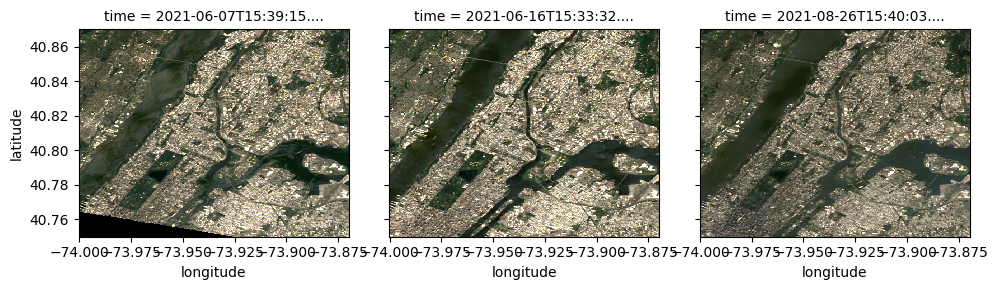

In [11]:
plot_data_landsat = scene_data_landsat[["red","green","blue"]].to_array()
plot_data_landsat.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

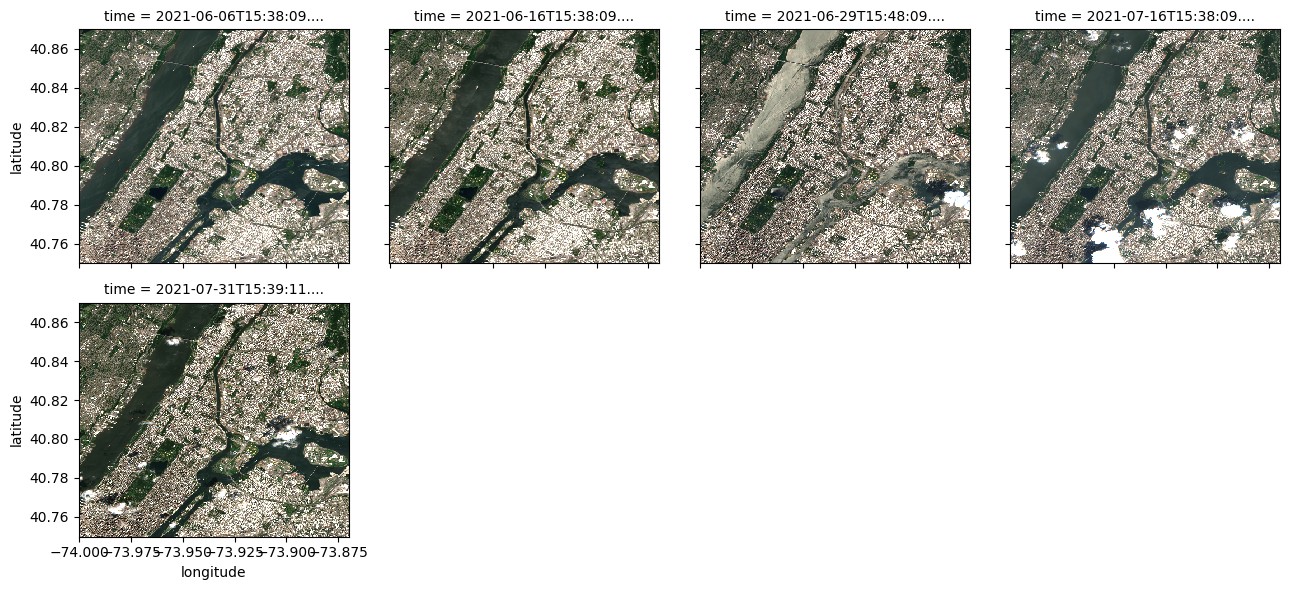

In [12]:
plot_data_sentinel = data_sentinel[["B04","B03","B02"]].to_array()
plot_data_sentinel.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()


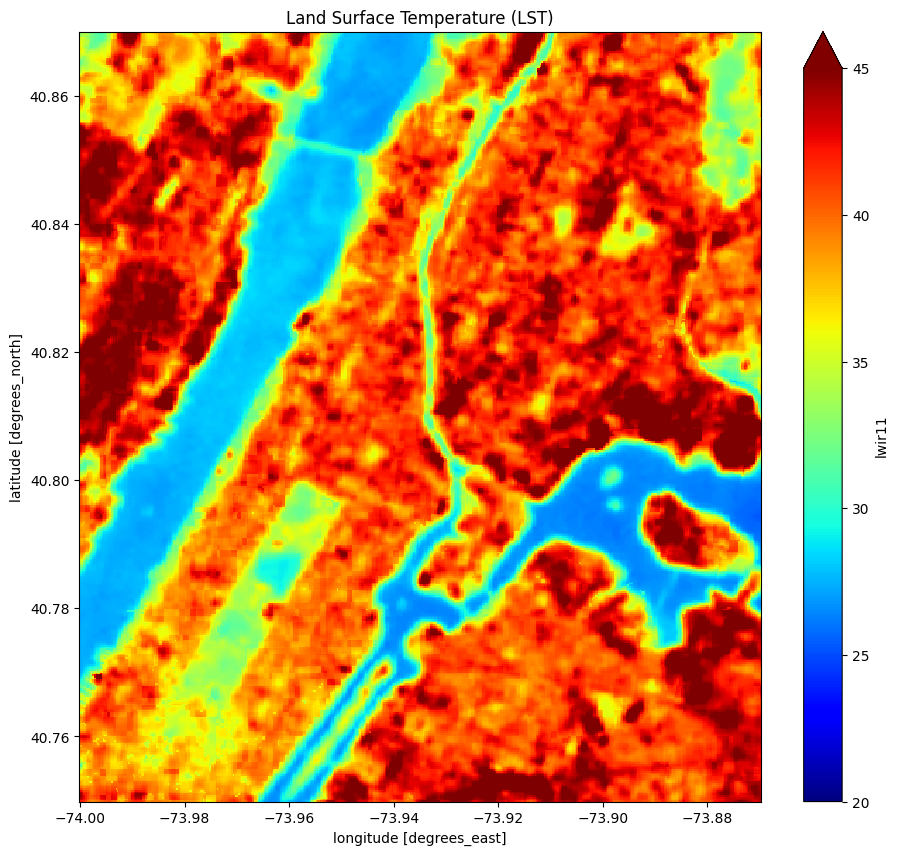

In [13]:
#None of the scene fits our exact time frame, so we'll just choose the clearest pic
scene = 2
fig, ax = plt.subplots(figsize=(11,10))
data_landsat.isel(time=scene).lwir11.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('on')
plt.show()

In [14]:
"""
For LandSat
"""
#isolate chose scene and data
surface_temp = data_landsat.isel(time=scene)
filename_landsat = "LandSat_SurfaceTemp.tiff"

#determine dimension of the scene
height = surface_temp.dims["latitude"]
width = surface_temp.dims["longitude"]

# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt_landsat = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
surface_temp.rio.write_crs("epsg:4326", inplace=True)
surface_temp.rio.write_transform(transform=gt_landsat, inplace=True);


with rasterio.open(filename_landsat,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt_landsat,count=1,compress='lzw',dtype='float64') as dst:
    dst.write(surface_temp.lwir11,1)
    dst.close()

In [15]:
"""
For sentinel
"""
filename_sentinel = "Sentinel_Bands.tiff"
data_slice_sentinel = data_sentinel.isel(time=scene)

height = data_slice_sentinel.dims["latitude"]
width = data_slice_sentinel.dims["longitude"]

gt_sentinel = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data_slice_sentinel.rio.write_crs("epsg:4326", inplace=True)
data_slice_sentinel.rio.write_transform(transform=gt_sentinel, inplace=True);

# Create the GeoTIFF output file using the defined parameters
with rasterio.open(filename_sentinel,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt_sentinel,count=11,compress='lzw',dtype='float64') as dst:
    dst.write(data_slice_sentinel.B01,1)
    dst.write(data_slice_sentinel.B02,2)
    dst.write(data_slice_sentinel.B03,3)
    dst.write(data_slice_sentinel.B04,4)
    dst.write(data_slice_sentinel.B05,5)
    dst.write(data_slice_sentinel.B06,6)
    dst.write(data_slice_sentinel.B07,7)
    dst.write(data_slice_sentinel.B08,8)
    dst.write(data_slice_sentinel.B8A,9)
    dst.write(data_slice_sentinel.B11,10)
    dst.write(data_slice_sentinel.B12,11)
    dst.close()

3. Map data using Geotiff file

In [16]:
def map_satellite_data(tiff_path, csv_path):

  data = rxr.open_rasterio(tiff_path)
  tiff_crs = data.rio.crs

  df = pd.read_csv(csv_path)
  latitudes = df['Latitude'].values
  longitudes = df['Longitude'].values

  proj_wgs84 = Proj(init='epsg:4326')
  proj_tiff = Proj(tiff_crs)
  transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

  B01_values = []
  B02_values = []
  B03_values = []
  B04_values = []
  B05_values = []
  B06_values = []
  B07_values = []
  B08_values = []
  B8A_values = []
  B11_values = []
  B12_values = []

  for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

      B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
      B01_values.append(B01_value)

      B02_value = data.sel(x=lon, y=lat,  band=2, method="nearest").values
      B02_values.append(B02_value)

      B03_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
      B03_values.append(B03_value)

      B04_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
      B04_values.append(B04_value)

      B05_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
      B05_values.append(B05_value)

      B06_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
      B06_values.append(B06_value)

      B07_value = data.sel(x=lon, y=lat, band=7, method="nearest").values
      B07_values.append(B07_value)

      B08_value = data.sel(x=lon, y=lat, band=8, method="nearest").values
      B08_values.append(B08_value)

      B8A_value = data.sel(x=lon, y=lat, band=9, method="nearest").values
      B8A_values.append(B8A_value)

      B11_value = data.sel(x=lon, y=lat, band=10, method="nearest").values
      B11_values.append(B11_value)

      B12_value = data.sel(x=lon, y=lat, band=11, method="nearest").values
      B12_values.append(B12_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
  df_sentinel = pd.DataFrame()
  df_sentinel['B01'] = B01_values
  df_sentinel['B02'] = B02_values
  df_sentinel['B03'] = B03_values
  df_sentinel['B04'] = B04_values
  df_sentinel['B05'] = B05_values
  df_sentinel['B06'] = B06_values
  df_sentinel['B07'] = B07_values
  df_sentinel['B08'] = B08_values
  df_sentinel['B8A'] = B8A_values
  df_sentinel['B11'] = B11_values
  df_sentinel['B12'] = B12_values

  return df_sentinel


In [17]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_sat_data(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)
    surface_temp_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        surface_temp_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        surface_temp_values.append(surface_temp_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df_landset = pd.DataFrame()
    df_landset['surface_temp'] = surface_temp_values
    return df_landset

In [18]:
surface_temp = map_sat_data("LandSat_SurfaceTemp.tiff", CSV_PATH)
sentinel_data = map_satellite_data("Sentinel_Bands.tiff", CSV_PATH)

Mapping values: 100%|██████████| 11229/11229 [02:05<00:00, 89.45it/s]


In [19]:
"""
More calculations on:

NVDI:
(NIR-RED)/(NIR+RED)

NRDE:
(NIR - Red Edge) / (NIR + Red Edge)

NDBI:
(SWIR - NIR) / (SWIR + NIR)

NDWI:
(NIR - SWIR) / (NIR + SWIR)

GCVI:
(NIR / GREEN ) - 1

"""

'\nMore calculations on:\n\nNVDI:\n(NIR-RED)/(NIR+RED)\n\nNRDE:\n(NIR - Red Edge) / (NIR + Red Edge)\n\nNDBI:\n(SWIR - NIR) / (SWIR + NIR)\n\nNDWI:\n(NIR - SWIR) / (NIR + SWIR)\n\nGCVI:\n(NIR / GREEN ) - 1\n\n'

In [20]:
sentinel_data['NDVI'] = (sentinel_data['B08'] - sentinel_data['B04']) / (sentinel_data['B08'] + sentinel_data['B04'])
sentinel_data['NDVI'] = sentinel_data['NDVI'].replace([np.inf, -np.inf], np.nan)

sentinel_data['NDBI'] = (sentinel_data['B11'] - sentinel_data['B08']) / (sentinel_data['B11'] + sentinel_data['B08'])
sentinel_data['NDBI'] = sentinel_data['NDBI'].replace([np.inf, -np.inf], np.nan)

sentinel_data['NDWI'] = (sentinel_data['B03'] - sentinel_data['B08']) / (sentinel_data['B03'] + sentinel_data['B08'])
sentinel_data['NDWI'] = sentinel_data['NDWI'].replace([np.inf, -np.inf], np.nan)

sentinel_data['GCVI'] = (sentinel_data['B8A']/sentinel_data['B03']) - 1
sentinel_data['GCVI'] = sentinel_data['GCVI'].replace([np.inf, -np.inf], np.nan)

sentinel_data['NRDE'] = (sentinel_data['B8A'] - sentinel_data['B06']) / (sentinel_data['B8A'] + sentinel_data['B06'])
sentinel_data['NRDE'] = sentinel_data['NRDE'].replace([np.inf, -np.inf], np.nan)

In [21]:
sentinel_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI,GCVI,NRDE
0,782.0,880.0,959.0,925.0,889.0,1061.0,1280.0,1467.0,1139.0,1289.0,1131.0,0.226589,-0.064586,-0.209398,0.187696,0.035455
1,782.0,880.0,959.0,925.0,889.0,1061.0,1280.0,1467.0,1139.0,1289.0,1131.0,0.226589,-0.064586,-0.209398,0.187696,0.035455
2,782.0,552.0,641.0,640.0,1098.0,1812.0,1979.0,2242.0,2148.0,1530.0,1100.0,0.555864,-0.188759,-0.555324,2.351014,0.084848
3,782.0,626.0,718.0,695.0,906.0,1472.0,1680.0,1719.0,1856.0,1391.0,1026.0,0.424192,-0.105466,-0.410751,1.584958,0.115385
4,782.0,626.0,718.0,695.0,906.0,1472.0,1680.0,1719.0,1856.0,1391.0,1026.0,0.424192,-0.105466,-0.410751,1.584958,0.115385


In [22]:
surface_temp.head()

,surface_temp
0,42.393024500000024
1,42.393024500000024
2,41.442814940000005
3,41.15228324000003
4,41.15228324000003


In [23]:
def combine_datasets(dataset1, dataset2, dataset3):
  #axis 1 as in new columsn
  data = pd.concat([dataset1, dataset2, dataset3], axis=1)
  return data

In [24]:
uhi_index = combine_datasets(df, surface_temp, sentinel_data)
uhi_index['UHI Index'] = uhi_index.pop("UHI Index")
uhi_index.head(20)

,Longitude,Latitude,datetime,surface_temp,B01,B02,B03,B04,B05,B06,...,B08,B8A,B11,B12,NDVI,NDBI,NDWI,GCVI,NRDE,UHI Index
0,-73.909167,40.813107,2021-07-24,42.393024500000024,782.0,880.0,959.0,925.0,889.0,1061.0,...,1467.0,1139.0,1289.0,1131.0,0.226589,-0.064586,-0.209398,0.187696,0.035455,1.030289
1,-73.909187,40.813045,2021-07-24,42.393024500000024,782.0,880.0,959.0,925.0,889.0,1061.0,...,1467.0,1139.0,1289.0,1131.0,0.226589,-0.064586,-0.209398,0.187696,0.035455,1.030289
2,-73.909215,40.812978,2021-07-24,41.442814940000005,782.0,552.0,641.0,640.0,1098.0,1812.0,...,2242.0,2148.0,1530.0,1100.0,0.555864,-0.188759,-0.555324,2.351014,0.084848,1.023798
3,-73.909242,40.812908,2021-07-24,41.15228324000003,782.0,626.0,718.0,695.0,906.0,1472.0,...,1719.0,1856.0,1391.0,1026.0,0.424192,-0.105466,-0.410751,1.584958,0.115385,1.023798
4,-73.909257,40.812845,2021-07-24,41.15228324000003,782.0,626.0,718.0,695.0,906.0,1472.0,...,1719.0,1856.0,1391.0,1026.0,0.424192,-0.105466,-0.410751,1.584958,0.115385,1.021634
5,-73.909280,40.812777,2021-07-24,41.15228324000003,782.0,626.0,718.0,695.0,906.0,1472.0,...,1719.0,1856.0,1391.0,1026.0,0.424192,-0.105466,-0.410751,1.584958,0.115385,1.021634
6,-73.909312,40.812710,2021-07-24,41.15228324000003,782.0,626.0,718.0,695.0,906.0,1472.0,...,1719.0,1856.0,1391.0,1026.0,0.424192,-0.105466,-0.410751,1.584958,0.115385,1.015143
7,-73.909340,40.812643,2021-07-24,41.063414720000026,1009.0,564.0,636.0,583.0,1375.0,1555.0,...,1762.0,1907.0,1932.0,1469.0,0.502772,0.046021,-0.469558,1.998428,0.101675,1.015143
8,-73.909363,40.812562,2021-07-24,41.063414720000026,1009.0,564.0,636.0,583.0,1375.0,1555.0,...,1762.0,1907.0,1932.0,1469.0,0.502772,0.046021,-0.469558,1.998428,0.101675,1.012979
9,-73.909383,40.812485,2021-07-24,41.063414720000026,1009.0,564.0,636.0,583.0,1375.0,1555.0,...,1762.0,1907.0,1932.0,1469.0,0.502772,0.046021,-0.469558,1.998428,0.101675,1.012979


In [25]:
#checking for nan
uhi_index.isna().any().any()

False

In [26]:
X = uhi_index[['surface_temp', 'NDVI', 'NDBI', 'NDWI', 'GCVI', 'NRDE','B01', 'B02', 'B03', 'B04', 'B05','B06','B07','B08','B8A','B11','B12']]
y = uhi_index['UHI Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)


In [27]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [28]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [29]:
insample_predictions = model.predict(X_train)
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9636123888056702

In [30]:
outsample_predictions = model.predict(X_test)
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.8171633591160413

In [31]:
"""
Submission
"""
Submission_template = '/content/drive/MyDrive/Colab Notebooks/Submission_template_UHI2025-v2.csv'

In [32]:
test_file = pd.read_csv(Submission_template)
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [33]:
# Mapping satellite data for submission.
predict_sentinel_data = map_satellite_data('Sentinel_Bands.tiff',Submission_template)

Mapping values: 100%|██████████| 1040/1040 [00:11<00:00, 92.36it/s]


In [34]:
predict_sentinel_data['NDVI'] = (predict_sentinel_data['B08'] - predict_sentinel_data['B04']) / (predict_sentinel_data['B08'] + predict_sentinel_data['B04'])
predict_sentinel_data['NDVI'] = predict_sentinel_data['NDVI'].replace([np.inf, -np.inf], np.nan)

predict_sentinel_data['NDBI'] = (predict_sentinel_data['B11'] - predict_sentinel_data['B08']) / (predict_sentinel_data['B11'] + predict_sentinel_data['B08'])
predict_sentinel_data['NDBI'] = predict_sentinel_data['NDBI'].replace([np.inf, -np.inf], np.nan)

predict_sentinel_data['NDWI'] = (predict_sentinel_data['B03'] - predict_sentinel_data['B08']) / (predict_sentinel_data['B03'] + predict_sentinel_data['B08'])
sentinel_data['NDWI'] = predict_sentinel_data['NDWI'].replace([np.inf, -np.inf], np.nan)

predict_sentinel_data['GCVI'] = (predict_sentinel_data['B8A']/predict_sentinel_data['B03']) - 1
predict_sentinel_data['GCVI'] = predict_sentinel_data['GCVI'].replace([np.inf, -np.inf], np.nan)

predict_sentinel_data['NRDE'] = (predict_sentinel_data['B8A'] - predict_sentinel_data['B06']) / (predict_sentinel_data['B8A'] + predict_sentinel_data['B06'])
predict_sentinel_data['NRDE'] = predict_sentinel_data['NRDE'].replace([np.inf, -np.inf], np.nan)

In [35]:
predict_sentinel_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI,GCVI,NRDE
0,703.0,539.0,640.0,533.0,903.0,1938.0,2318.0,1794.0,2407.0,1537.0,983.0,0.541899,-0.077154,-0.474117,2.760937,0.107940
1,1131.0,823.0,934.0,1047.0,1137.0,1868.0,2138.0,2025.0,2282.0,1644.0,1180.0,0.318359,-0.103843,-0.368706,1.443255,0.099759
2,972.0,834.0,895.0,956.0,907.0,1037.0,1201.0,1120.0,1082.0,1415.0,1220.0,0.078998,0.116371,-0.111663,0.208939,0.021236
3,1011.0,1020.0,1296.0,1439.0,1976.0,2041.0,2178.0,1613.0,2520.0,3043.0,2970.0,0.057012,0.307131,-0.108972,0.944444,0.105021
4,1153.0,494.0,740.0,671.0,1787.0,2898.0,3129.0,2363.0,2997.0,2734.0,2280.0,0.557680,0.072788,-0.523042,3.050000,0.016794


In [36]:
# Mapping satellite data with training data.
predict_landset_data = map_sat_data('LandSat_SurfaceTemp.tiff', Submission_template)

Mapping values: 100%|██████████| 1040/1040 [00:00<00:00, 1076.17it/s]


In [37]:
"""
Joining the predictor variable and response variables
"""
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [38]:
# Combining ground data and final data into a single dataset.
predict_uhi_data = combine_two_datasets(predict_sentinel_data,predict_landset_data)
predict_uhi_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI,GCVI,NRDE,surface_temp
0,703.0,539.0,640.0,533.0,903.0,1938.0,2318.0,1794.0,2407.0,1537.0,983.0,0.541899,-0.077154,-0.474117,2.760937,0.107940,40.178147540000055
1,1131.0,823.0,934.0,1047.0,1137.0,1868.0,2138.0,2025.0,2282.0,1644.0,1180.0,0.318359,-0.103843,-0.368706,1.443255,0.099759,40.178147540000055
2,972.0,834.0,895.0,956.0,907.0,1037.0,1201.0,1120.0,1082.0,1415.0,1220.0,0.078998,0.116371,-0.111663,0.208939,0.021236,38.16835178000002
3,1011.0,1020.0,1296.0,1439.0,1976.0,2041.0,2178.0,1613.0,2520.0,3043.0,2970.0,0.057012,0.307131,-0.108972,0.944444,0.105021,40.311450320000006
4,1153.0,494.0,740.0,671.0,1787.0,2898.0,3129.0,2363.0,2997.0,2734.0,2280.0,0.557680,0.072788,-0.523042,3.050000,0.016794,37.97694266000002


In [39]:
# Feature Scaling
submission_predict_data = predict_uhi_data.values
transformed_submission_data = sc.transform(submission_predict_data)
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [40]:
#Displaying the sample submission dataframe
submission_df.head(20)

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,1.001292
1,-73.971928,40.788875,1.002021
2,-73.967080,40.789080,1.002716
3,-73.972550,40.789082,1.003140
4,-73.969697,40.787953,1.002948
5,-73.970212,40.784183,1.003022
6,-73.969752,40.784708,1.003221
7,-73.966767,40.788863,1.003297
8,-73.971303,40.788585,1.002381
9,-73.966635,40.784183,1.000981


In [41]:
file_path = '/content/drive/MyDrive/Colab Notebooks/submission_df_trial6.csv'
submission_df.to_csv(file_path, index = False)

 *“WIND”*

1) Match the time and choose the wind direction and windspeed needed

2) predict the model and estimate the latitudes and longitudes areas that affected

3) merged with the data and predict the UHI index